In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [145]:
df = pd.read_csv('./output/data/merged_df.csv')

In [146]:
df.columns

Index(['file_path', 'sampling_rate', 'rms', 'dbfs', 'label', 'duration',
       'mfcc_1_mean', 'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_4_mean',
       'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean', 'mfcc_8_mean',
       'mfcc_9_mean', 'mfcc_10_mean', 'mfcc_11_mean', 'mfcc_12_mean',
       'mfcc_13_mean', 'mfcc_14_mean', 'mfcc_15_mean', 'mfcc_16_mean',
       'mfcc_17_mean', 'mfcc_18_mean', 'mfcc_19_mean', 'mfcc_20_mean',
       'mfcc_21_mean', 'mfcc_22_mean', 'mfcc_23_mean', 'mfcc_24_mean',
       'mfcc_25_mean', 'mfcc_26_mean', 'mfcc_27_mean', 'mfcc_28_mean',
       'mfcc_29_mean', 'mfcc_30_mean'],
      dtype='object')

In [147]:
# Drop the 'file_path' column
data = df.drop(columns=['file_path', 'sampling_rate'])

# Convert 'label' column values from 'fake' and 'real' to 0 and 1
data['label'] = data['label'].apply(lambda x: 0 if x == 'fake' else 1)

# Display the updated dataframe
data.head()

,rms,dbfs,label,duration,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,...,mfcc_21_mean,mfcc_22_mean,mfcc_23_mean,mfcc_24_mean,mfcc_25_mean,mfcc_26_mean,mfcc_27_mean,mfcc_28_mean,mfcc_29_mean,mfcc_30_mean
0,0.061510,-24.220951,1,6.840000,-304.341270,113.709097,-44.021291,28.256102,13.641230,-13.230529,...,-7.879508,-11.564848,-7.241586,-3.500644,-8.572959,-7.769196,-6.200805,-9.601032,-1.045484,1.696635
1,0.060355,-24.385653,1,6.070000,-288.430056,156.781227,-42.138849,21.731352,9.175248,-37.561261,...,-10.782125,-11.156759,-9.278637,-7.561083,-6.570046,-6.295412,-5.074236,-3.588240,-3.976979,-4.318006
2,0.034738,-29.183570,1,5.920000,-313.729559,133.650065,-45.776206,-0.649869,-4.962584,-27.823752,...,-7.809381,-3.840896,-4.639575,-5.083332,-2.645830,-3.523515,-4.064678,-1.823462,-1.784046,-3.711713
3,0.101507,-19.870003,1,9.849958,-338.528304,110.269715,-26.445261,7.784086,12.008307,-15.176674,...,-6.991639,-4.952648,-4.918112,-5.376414,-5.329774,-4.305240,-3.679742,-3.917728,-2.481780,-1.619357
4,0.027996,-31.057756,1,5.529958,-288.435487,117.139206,-53.460400,14.722782,-4.214957,-40.313201,...,-8.898185,-8.144262,-5.093298,0.412901,0.513141,1.108503,1.737505,-0.865436,0.617007,0.743553


In [148]:
data.shape

(17423, 34)

In [149]:
features = data.drop(columns=['label', 'rms', 'dbfs', 'duration'], axis=1).copy()
labels = data['label']

In [150]:
features.columns

Index(['mfcc_1_mean', 'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_4_mean',
       'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean', 'mfcc_8_mean',
       'mfcc_9_mean', 'mfcc_10_mean', 'mfcc_11_mean', 'mfcc_12_mean',
       'mfcc_13_mean', 'mfcc_14_mean', 'mfcc_15_mean', 'mfcc_16_mean',
       'mfcc_17_mean', 'mfcc_18_mean', 'mfcc_19_mean', 'mfcc_20_mean',
       'mfcc_21_mean', 'mfcc_22_mean', 'mfcc_23_mean', 'mfcc_24_mean',
       'mfcc_25_mean', 'mfcc_26_mean', 'mfcc_27_mean', 'mfcc_28_mean',
       'mfcc_29_mean', 'mfcc_30_mean'],
      dtype='object')

In [151]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, LSTM, Bidirectional, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from utils import create_sequences
import pickle

In [152]:
# 1. Create sequences
sequence_length = 10  # Example value, adjust as needed
overlap = 5  # Example value, adjust as needed
print(features.shape)
sequences, indices = create_sequences(features, sequence_length, overlap)
labels = labels[indices]

# 2. Pad sequences
padded_sequences = pad_sequences(
    sequences, maxlen=2, padding="pre", truncating="post"
)

# 1. First split the data
X_train, X_val, y_train, y_val = train_test_split(
    padded_sequences, 
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# 2. Fit scaler only on training data
scaler = StandardScaler()
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)

# Fit on training, transform both
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_val_scaled = scaler.transform(X_val_reshaped)

# 3. Reshape back
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_val_scaled = X_val_scaled.reshape(X_val.shape)
# Save the train and validation data
np.save('./output/X_train.npy', X_train)
np.save('./output/X_val.npy', X_val)
np.save('./output/y_train.npy', y_train)
np.save('./output/y_val.npy', y_val)
with open('./output/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

(17423, 30)


In [153]:
# 2. Create LSTM model
model = Sequential()
input_shape = (padded_sequences.shape[1], padded_sequences.shape[2])
model.add(Input(shape=input_shape))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dense(32, activation='relu', kernel_regularizer='l2'))
model.add(Dense(1, activation='sigmoid'))

# 3. Compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, clipvalue=1.0), loss="binary_crossentropy", metrics=["accuracy"])

In [154]:
# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss")
def scheduler(epoch, lr):
    if epoch > 0 and epoch % 3 == 0:
        return lr * 0.2
    return lr

reduce_lr = LearningRateScheduler(scheduler)

# 4. Training with separate validation data
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

with open('./output/history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 25s 218ms/step - accuracy: 0.7115 - loss: 0.9944 - val_accuracy: 0.8364 - val_loss: 0.5010 - learning_rate: 0.0010
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 182ms/step - accuracy: 0.8701 - loss: 0.4210 - val_accuracy: 0.8680 - val_loss: 0.3546 - learning_rate: 0.0010
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - accuracy: 0.8935 - loss: 0.2877 - val_accuracy: 0.8608 - val_loss: 0.3186 - learning_rate: 0.0010
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - accuracy: 0.9006 - loss: 0.2510 - val_accuracy: 0.8637 - val_loss: 0.3130 - learning_rate: 2.0000e-04
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step - accuracy: 0.9176 - loss: 0.2277 - val_accuracy: 0.8694 - val_loss: 0.3107 - learning_rate: 2.0000e-04
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - accuracy: 0.9244 - loss: 0.2138 - val_accuracy: 0.8680 - val_loss: 0.3062 - learning_rate: 2.0000e-04
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - accuracy

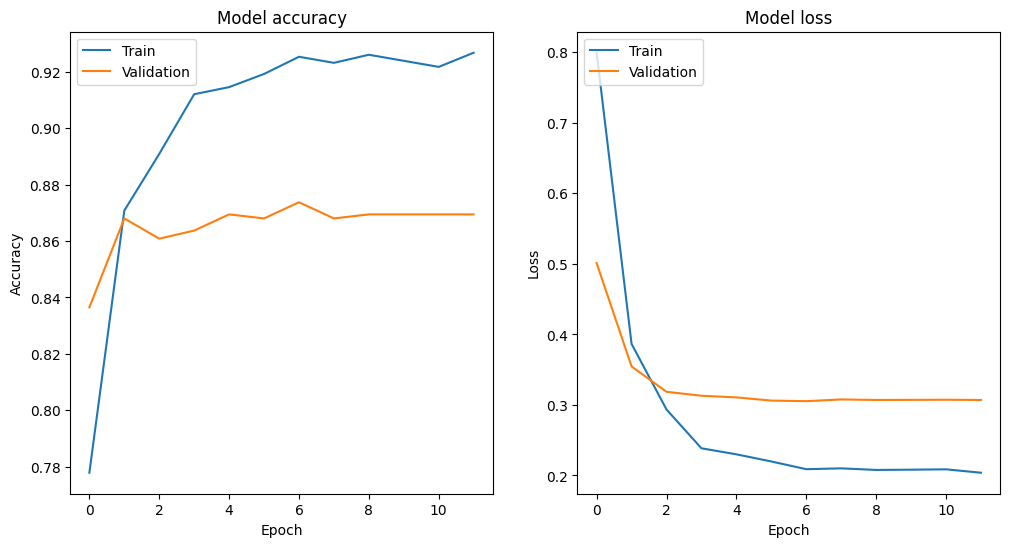

In [155]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluation

In [156]:
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       348
           1       0.87      0.88      0.88       349

    accuracy                           0.87       697
   macro avg       0.87      0.87      0.87       697
weighted avg       0.87      0.87      0.87       697



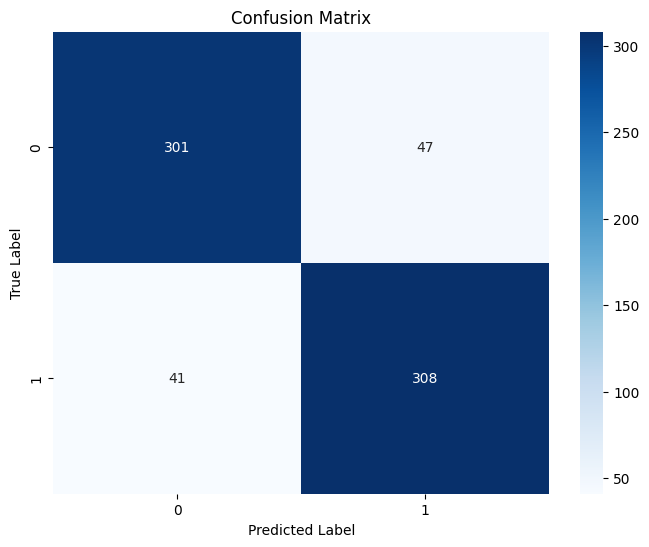

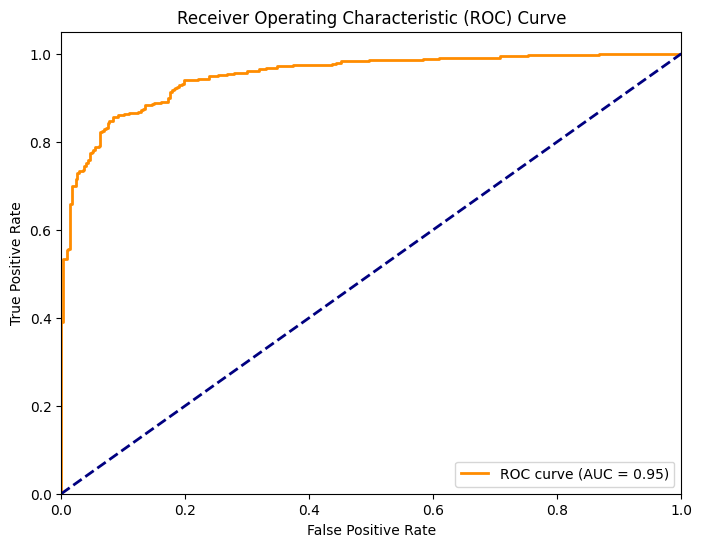


Detailed Metrics:
AUC-ROC Score: 0.9505
Accuracy: 0.8737
True Negatives: 301
False Positives: 47
False Negatives: 41
True Positives: 308


In [157]:
# 1. Load model and predict
model = keras.models.load_model("best_model.keras")
y_pred = model.predict(X_val_scaled)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

# 2. Print classification metrics
print("\nClassification Report:")
print(classification_report(y_val, y_pred_binary))

# 3. Create confusion matrix
cm = confusion_matrix(y_val, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 5. Print additional metrics
print("\nDetailed Metrics:")
print(f"AUC-ROC Score: {roc_auc:.4f}")
print(f"Accuracy: {(y_pred_binary == y_val).mean():.4f}")
print(f"True Negatives: {cm[0][0]}")
print(f"False Positives: {cm[0][1]}")
print(f"False Negatives: {cm[1][0]}")
print(f"True Positives: {cm[1][1]}")